In [63]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import datetime as dt

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect


# Reflect Tables into SQLAlchemy ORM

In [2]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [3]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [4]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [5]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [6]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [7]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [8]:
columns = inspector.get_columns('measurement')
for column in columns:
    primary = ""
    if column['primary_key'] == 1:
        primary = "PK"
    print(column["name"],column["type"],primary)

id INTEGER PK
station TEXT 
date TEXT 
prcp FLOAT 
tobs FLOAT 


In [9]:
columns = inspector.get_columns('station')
for column in columns:
    primary = ""
    if column['primary_key'] == 1:
        primary = "PK"
    print(column["name"],column["type"],primary)

id INTEGER PK
station TEXT 
name TEXT 
latitude FLOAT 
longitude FLOAT 
elevation FLOAT 


<H2> Design a query to retrieve the last 12 months of precipitation data and plot the results. </H2>

In [39]:
#finding the last data point in the database 
latest = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(latest)

('2017-08-23',)


In [40]:
#making the date data accessible for manipulation using strptime
lastdate = dt.datetime.strptime(latest[0], '%Y-%m-%d')

# Calculate the date 1 year ago from the last data point in the database
querydt = dt.date(lastdate.year - 1, lastdate.month, lastdate.day)
querydt

datetime.date(2016, 8, 23)

In [41]:
# Perform a query to retrieve the data and precipitation scores
#session.query(measurement.prcp).group_by(measurement.date).all()
select = [measurement.date, measurement.prcp]
result =  session.query(*select).filter(measurement.date >= querydt).all()
result

[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0),
 ('2016-09-02', 0.0),
 ('2016-09-03', 0.0),
 ('2016-09-04', 0.03),
 ('2016-09-05', None),
 ('2016-09-06', None),
 ('2016-09-07', 0.05),
 ('2016-09-08', 0.0),
 ('2016-09-09', 0.03),
 ('2016-09-10', 0.0),
 ('2016-09-11', 0.05),
 ('2016-09-12', 0.0),
 ('2016-09-13', 0.02),
 ('2016-09-14', 1.32),
 ('2016-09-15', 0.42),
 ('2016-09-16', 0.06),
 ('2016-09-17', 0.05),
 ('2016-09-18', 0.0),
 ('2016-09-19', 0.0),
 ('2016-09-20', 0.0),
 ('2016-09-21', 0.0),
 ('2016-09-22', 0.02),
 ('2016-09-23', 0.0),
 ('2016-09-24', 0.0),
 ('2016-09-25', 0.0),
 ('2016-09-26', 0.06),
 ('2016-09-27', 0.02),
 ('2016-09-28', 0.0),
 ('2016-09-29', 0.0),
 ('2016-09-30', 0.0),
 ('2016-10-01', 0.0),
 ('2016-10-02', 0.0),
 ('2016-10-03', 0.0),
 ('2016-10-04', 0.0),
 ('2016-10-05', 0.0),
 ('2016-10-06'

In [44]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date

precip = pd.DataFrame(result, columns= ['Date','Precipitation'])
precip = precip.dropna(how='any').sort_values(['Date'], ascending = True).set_index("Date")
precip.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


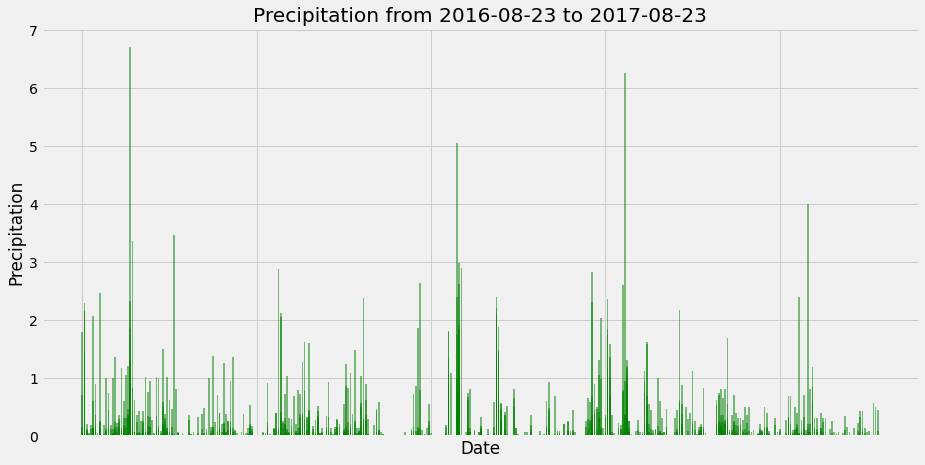

In [66]:
# Use Pandas Plotting with Matplotlib to plot the data

datex = precip.index.tolist()
precipy = precip.Precipitation.tolist()

plt.figure(figsize = (14,7))
plt.bar(datex,precipy, color = 'g', alpha = 0.5, align = 'center', label = 'Precipitaiton')

plt.tick_params(axis = 'x', which = 'both', bottom = False, top = False, labelbottom = False)
major_ticks = np.arange(0,400,80)
plt.xticks(major_ticks)

plt.title(f"Precipitation from {querydt} to {latest[0]}")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.grid(which = 'major', axis = 'both', linestyle = '-')
plt.show()

In [67]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [68]:
# Design a query to show how many stations are available in this dataset?
session.query(station.id).count()

9

In [70]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active = session.query(measurement.station, func.count(measurement.id)).group_by(measurement.station).order_by(func.count(measurement.id).desc()).all()
active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [71]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
mostactive = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).first()
mostactive

(54.0, 85.0, 71.66378066378067)

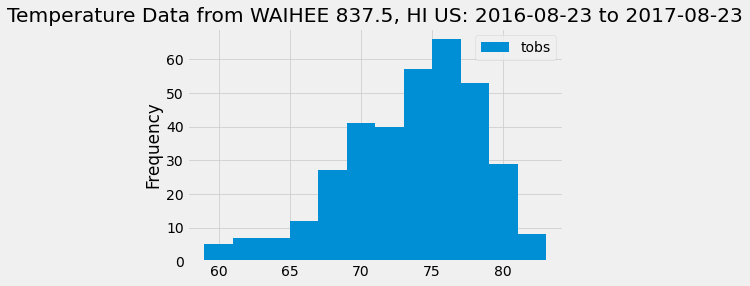

In [78]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
observations = session.query(measurement.tobs).filter(measurement.station == active[0][0]).filter(measurement.date >= querydt).all()
#observations
temps = list(np.ravel(observations))

stations = session.query(station.station, station.name, station.latitude, station.longitude, station.elevation).all()
station_desc = pd.DataFrame(stations, columns = ['Station', 'Name', 'Latitude', 'Longitude', 'Elevation'])
station_name = station_desc.loc[station_desc.Station == active[0][0], 'Name'].tolist()[0]

plt.hist(temps, bins = 12, rwidth = 1.0, label = 'tobs')
plt.grid(axis = 'both', alpha = 0.75)
plt.title(f"Temperature Data from {station_name}: {querydt} to {latest[0]}")
plt.ylabel('Frequency')
plt.legend()          

## Bonus Challenge Assignment

In [79]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
